In this notebook I will take the keyword list and order them by the words most commonly used

In [235]:
from pandas import json_normalize
import pip._vendor.requests 
import os
import json
from dotenv import load_dotenv
import csv
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import time
from wordcloud import WordCloud

In [183]:
load_dotenv()

# To get bearer token environment variable
bearer_token = os.environ.get("BEARER-TOKEN")

search_url = "https://api.twitter.com/2/tweets/counts/all"

# Optional params: start_time,end_time,since_id,until_id,next_token,granularity

In [184]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveTweetCountsPython"
    return r

In [185]:
def connect_to_endpoint(url, params):
    response = pip._vendor.requests.request("GET", search_url, auth=bearer_oauth, params=params)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [186]:
def query_params(next_token, queryKeyword, start, end):
   
    queryStr = f'{queryKeyword} lang:en -is:retweet place_country:gb'
    queryDict = {   'query': queryStr,
                    'granularity': 'day',
                    'start_time': start,
                    'end_time': end,
                    'next_token': next_token
                    }
    return queryDict


In [187]:
def getKeywordsListFromCsv(csvFile):
    with open(csvFile, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    del data[0]
    return data

keyWordListofLists = getKeywordsListFromCsv('AsianKeywords.csv')
print(keyWordListofLists)
print(type(keyWordListofLists))
print(type(keyWordListofLists[0]))
print(type(keyWordListofLists[0][0]))
print(len(keyWordListofLists))

# keyWordListofLists = [['asian'], ['asian indian'], ['asians'], ['hello'], ['tesla'], ['motors']]


[['asian'], ['asian indian'], ['asians'], ['asiatic'], ['azn'], ['brunei'], ['bruneian'], ['burma'], ['burmese'], ['cambodia'], ['cambodian'], ['chamorro'], ['chiegro'], ['china'], ['chinaman'], ['chinese'], ['ching chong'], ['chinina'], ['chink'], ['chinkerbell'], ['chinks'], ['christmas island'], ['coconut nigger'], ['cocos islands'], ['cracker jap'], ['dog eater'], ['dog muncher'], ['dothead'], ['east asian'], ['east timor'], ['egghead'], ['far eastern'], ['filipino'], ['filipinos'], ['fob'], ['gink'], ['goldfish monger'], ['goloid'], ['gook'], ['gookaniese'], ['gookemon'], ['gooky'], ['hong kong'], ['indonesia'], ['indonesian'], ['japan'], ['japanese'], ['japanigger'], ['jaundy boy'], ['karen people'], ['keeling islands'], ['korean'], ['koreans'], ['lao'], ['laos'], ['laotian'], ['lemonhead'], ['little hiroshima'], ['macao'], ['macau'], ['malaysia'], ['malaysian'], ['mongolia'], ['mongolian'], ['mongolians'], ['myanmar'], ['ninja'], ['nipponese'], ['noodle nigger'], ['north korea']

In [188]:
def get_tweet_counts_to_df(queryKeyword, startDate, endDate):
    next_token = {}
    finished = False
    data = []
   
    while finished == False:
        # print("about to create jsonresponse in get_tweet_count_to_df")
        json_response = connect_to_endpoint(search_url, query_params(next_token, queryKeyword, startDate, endDate))
        # print(json_response)
        for r in json_response['data']:
            start = r['start']
            count = r['tweet_count']
            startDate = datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f%z')
            result = [startDate, count]
            data.append(result)
            
        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
        else:
            finished = True
    
    sortedData = sorted(data, key=itemgetter(0))

    df = pd.DataFrame(sortedData, columns=['date', 'tweetCount'])
    return df

# tweetCountsDf = get_tweet_counts_to_df()

In [189]:
def getSumTweetCountFromDf(tweetCountDf):
    return tweetCountDf['tweetCount'].sum()

In [ ]:
def getKeywordsDfOrderedBySum(keywordList, startDate, endDate):
    keywordsAndSums = []
    for x in range(0, len(keywordList)):
        keyword = keywordList[x][0]
        # print("got keyword: ")
        # print(type(keyword))
        # print(keyword)
        df = get_tweet_counts_to_df(keyword, startDate, endDate)
        sum = getSumTweetCountFromDf(df)
        result = [keyword, sum]
        print(result)
        keywordsAndSums.append(result)
        time.sleep(1)
    
    sortedKeywordsBySum = sorted(keywordsAndSums, key=itemgetter(1), reverse=True)
    return pd.DataFrame(sortedKeywordsBySum, columns=['keyword', 'sum'])
    

In [244]:
keywordsAndTweetCountSumDf = getKeywordsDfOrderedBySum(keyWordListofLists, '2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z')
print(keywordsAndTweetCountSumDf)

['asian', 952]
['asian indian', 19]
['asians', 148]
['asiatic', 5]
['azn', 1]
['brunei', 16]
['bruneian', 0]
['burma', 50]
['burmese', 35]
['cambodia', 75]
['cambodian', 7]
['chamorro', 1]
['chiegro', 0]
['china', 3584]
['chinaman', 3]
['chinese', 4063]
['ching chong', 3]
['chinina', 0]
['chink', 25]
['chinkerbell', 0]
['chinks', 10]
['christmas island', 29]
['coconut nigger', 0]
['cocos islands', 1]
['cracker jap', 0]
['dog eater', 1]
['dog muncher', 0]
['dothead', 0]
['east asian', 27]
['east timor', 0]
['egghead', 4]
['far eastern', 8]
['filipino', 58]
['filipinos', 7]
['fob', 78]
['gink', 0]
['goldfish monger', 0]
['goloid', 0]
['gook', 5]
['gookaniese', 0]
['gookemon', 0]
['gooky', 0]
['hong kong', 330]
['indonesia', 153]
['indonesian', 64]
['japan', 1283]
['japanese', 942]
['japanigger', 0]
['jaundy boy', 0]
['karen people', 45]
['keeling islands', 0]
['korean', 320]
['koreans', 27]
['lao', 31]
['laos', 16]
['laotian', 1]
['lemonhead', 1]
['little hiroshima', 2]
['macao', 1]
['ma

In [208]:
keywordsAndTweetCountSumDf2 = getKeywordsDfOrderedBySum(keyWordListofLists, '2019-01-01T00:00:00Z', '2019-02-01T00:00:00Z')
print(keywordsAndTweetCountSumDf2)

['asian', 982]
['asian indian', 14]
['asians', 103]
['asiatic', 4]
['azn', 6]
['brunei', 12]
['bruneian', 2]
['burma', 36]
['burmese', 42]
['cambodia', 92]
['cambodian', 21]
['chamorro', 0]
['chiegro', 0]
['china', 3118]
['chinaman', 3]
['chinese', 2764]
['ching chong', 4]
['chinina', 0]
['chink', 24]
['chinkerbell', 0]
['chinks', 10]
['christmas island', 18]
['coconut nigger', 0]
['cocos islands', 1]
['cracker jap', 0]
['dog eater', 2]
['dog muncher', 0]
['dothead', 0]
['east asian', 36]
['east timor', 2]
['egghead', 10]
['far eastern', 13]
['filipino', 74]
['filipinos', 11]
['fob', 96]
['gink', 1]
['goldfish monger', 0]
['goloid', 0]
['gook', 3]
['gookaniese', 0]
['gookemon', 0]
['gooky', 0]
['hong kong', 351]
['indonesia', 120]
['indonesian', 47]
['japan', 1481]
['japanese', 1194]
['japanigger', 0]
['jaundy boy', 0]
['karen people', 27]
['keeling islands', 0]
['korean', 417]
['koreans', 25]
['lao', 19]
['laos', 18]
['laotian', 0]
['lemonhead', 0]
['little hiroshima', 0]
['macao', 3]

Generating a word cloud of Asian-related keyword and the frequency of their use from jan 

In [247]:
def tweetCountDfToWordCloud(df, title):
    tempDict = df.to_dict('split')
    tempList = tempDict['data']
    frequenciesDict = {}
    for listItem in tempList:
        frequenciesDict[listItem[0]] = listItem[1]
    wc = WordCloud(background_color="black", max_words=150,  colormap='tab20c')
    wc.generate_from_frequencies(frequenciesDict)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize = 12)
    plt.show()



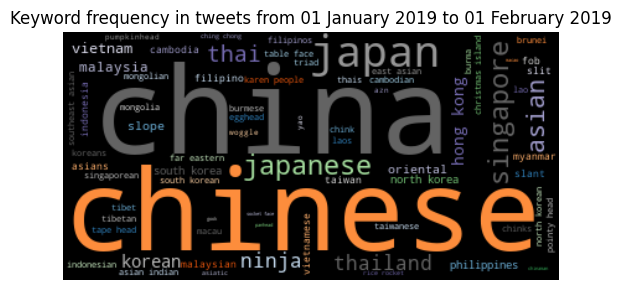

In [248]:
titleString = "Keyword frequency in tweets from 01 January 2019 to 01 February 2019"
tweetCountDfToWordCloud(keywordsAndTweetCountSumDf2, titleString)

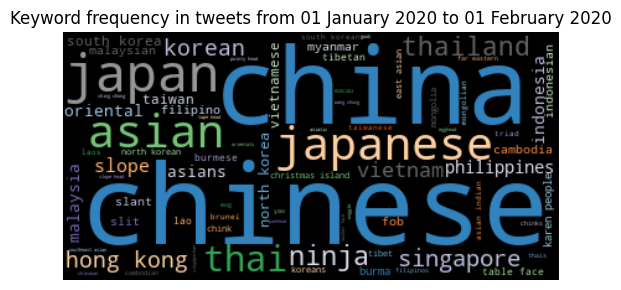

In [249]:
titleString = "Keyword frequency in tweets from 01 January 2020 to 01 February 2020"
tweetCountDfToWordCloud(keywordsAndTweetCountSumDf, titleString)